## Contents

- [Abstract](index.html)
- [Project Motivation](motivation.html)
- [Biological & Theoretical Background](background.html)
- [Model Structure](structure.html)
- [Usage](usage.html)
- [First Steps: Pyro](pyro.html)
- [Model Reconstruction](model.html)
- [Performance Comparison](performance.html)
- [Conclusions](conclusions.html)

# First Steps: Pyro

The first steps in reconstructing this model was to build a simple variational autoencoder that concerned itself solely with reconstruction loss, from which an actual model could be built.

For this, I experimented with PyTorch's probabilistic library, [pyro](http://pyro.ai/). This library contains pre-built modules for carrying out stochastic variational inference, and even has a [detailed instructional guide](http://pyro.ai/examples/vae.html) to building VAEs.

This library works by defining a model and a guide function and performing stochastic variational inference using to infer their relationship. More details can be found on [their website](http://pyro.ai/examples/svi_part_i.html).

Below is a walkthrough of the simple example model that was constructed to test variational autoencoders in this situation.

The following code is found in `pyro_model/pyro_vae.py`

In [2]:
import pt_helper # helper module for loading data

import torch
import torch.nn as nn
import numpy as np
import pyro
from torch.utils.data import DataLoader
import pyro.distributions as dist

# set up
pyro.enable_validation(True)
pyro.set_rng_seed(0)

First we define the decoder class. By inhering the nn.Module class, the different model classes defined can be connected.

In [ ]:
class Decoder(nn.Module):
    """
    takes latent variables z, passes through two hidden layers and returns reconstructed x.
    """
    def __init__(self, alph_size,seq_len, z_dim=30, hidden_architecture=[100,500]):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.hidden1 = nn.Linear(z_dim,hidden_architecture[0])
        self.hidden2 = nn.Linear(hidden_architecture[0],hidden_architecture[1])
        self.final = nn.Linear(hidden_architecture[1],(alph_size*seq_len))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        hidden1 = self.relu(self.hidden1(z))
        hidden2 = self.sigmoid(self.hidden2(hidden1))
        output = self.sigmoid(self.final(hidden2))
        return output

Next, we define the encoder class

In [ ]:
class Encoder(nn.Module):
    """
    Takes in data, returns mu and sigma for variational approximation of latent variable.
    """
    def __init__(self,alph_size,seq_len, z_dim=30, hidden_architecture=[1500,1500]):
        super(Encoder, self).__init__()
        self.hidden1 = nn.Linear((alph_size*seq_len),hidden_architecture[0])
        self.hidden2 = nn.Linear(hidden_architecture[0],hidden_architecture[1])
        self.final1 = nn.Linear(hidden_architecture[1],z_dim)
        self.final2 = nn.Linear(hidden_architecture[1],z_dim)
        self.relu = nn.ReLU()
        self.alph_size = alph_size
        self.seq_len = seq_len

    def forward(self, x):
        x = x.reshape(-1,self.seq_len*self.alph_size)
        hidden1 = self.relu(self.hidden1(x))
        hidden2 = self.relu(self.hidden2(hidden1))
        z_loc = self.final1(hidden2)
        z_scale = torch.exp(self.final2(hidden2))
        return z_loc, z_scale

With these constructed, we build the full model class, which calls these sub-classes, and defines the model/guide format used for pyro programming. The model serves as decoder, whilst the guide as the encoder.

In [ ]:
class VAE(nn.Module):
    def __init__(self, alph_size, seq_len, z_dim=30, encoder_architecture=[1500, 1500],
                 decoder_architecture=[100, 500], use_cuda=False):
        """
        Variational Autoencoder that defines the pyro structure of model and guide

        :param alph_size: size of alphabet
        :param seq_len: length of sequence
        :param z_dim: dimensions of latent space
        :param encoder_architecture: nodes per layer for encoder
        :param decoder_architecture: nodes per layer for decoder
        :param use_cuda: GPU command
        """
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        # call classes shared by nn.Module
        self.encoder = Encoder(alph_size,seq_len,z_dim, encoder_architecture)
        self.decoder = Decoder(alph_size,seq_len,z_dim, decoder_architecture)
        if use_cuda:
            self.cuda()
        # parameters required in functions
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.alph_size = alph_size
        self.seq_len = seq_len

    # define the model for conditional distribution p(x|z)p(z)
    def model(self, x):
        pyro.module('decoder', self.decoder) # adds decoder as a pyro module
        with pyro.plate('data', x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample('latent', dist.Normal(z_loc, z_scale).to_event(1))
            output = self.decoder.forward(z)
            # score against actual images
            pyro.sample('obs', dist.Bernoulli(output).to_event(1),
                        obs=x.reshape(-1, self.alph_size*self.seq_len))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_output(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note not sampled; this is non-bayesian)
        output = self.decoder(z)
        return output

To run this model, we also need to define a function for loaded and preparing data and a function for training each epoch:

In [ ]:
def loader_function(data, bs, nw, pm):
    """
    :param data: dataset specification for datahelper
    :param bs: batch size
    :param nw: number of workers for cuda
    :param pm: pin memory for GPU
    :return: a pytorch dataloader, alphabet and sequence size from datahelper
    """
    datahelper = pt_helper.DataHelper(dataset=data,calc_weights=True)
    x_train = datahelper.x_train.astype(np.float32)
    alph_size = datahelper.alphabet_size
    seq_len = datahelper.seq_len
    data_loader = DataLoader(x_train,batch_size=bs,
                             shuffle=True, num_workers=nw, pin_memory=pm)
    return data_loader, alph_size, seq_len


def train(svi, loader, use_cuda=False):
    """
    per epoch training function.

    :param svi: pyro svi module
    :param loader: data loader from loader_function
    :param use_cuda: GPU command
    :return: loss for that epoch
    """
    epoch_loss = 0.
    for x in loader:
        # for each batch, step with the SVI module.
        if use_cuda:
            x = x.cuda()
        epoch_loss += svi.step(x)

    normalizer_train = len(loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

finally, we define a script to run the model with defined parameters (found in `pyro_model/run_pyrovae.py`):

In [ ]:
# use following command to access files in another directory
# sys.path.insert(0, "path")
import pyro_vae
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO # svi module and ELBO loss module
from pyro.optim import Adam

# set up the parameters for the data, model and training

data_params = {
    "dataset"           :   "BLAT_ECOLX"
    }

# commented out parameters are for unimplemented components
model_params = {
    "bs"                :   100,
    "encode_dim_zero"   :   1500,
    "encode_dim_one"    :   1500,
    "decode_dim_zero"   :   100,
    "decode_dim_one"    :   500,
    "n_latent"          :   30,
    "learning_rate"     :   1.0e-3,
    # "logit_p"           :   0.001,
    # "sparsity"          :   "logit",
    # "final_decode_nonlin":  "sigmoid",
    # "final_pwm_scale"   :   True,
    # "n_pat"             :   4,
    "r_seed"            :   12345,
    # "conv_pat"          :   True,
    # "d_c_size"          :   40
    }

train_params = {
    "no_workers"        :   8,
    "num_updates"       :   300000,
    # "save_progress"     :   True,
    # "verbose"           :   True,
    # "save_parameters"   :   False,
    }

# speeds up training
cuda = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True

pyro.enable_validation(True)
pyro.set_rng_seed(model_params['r_seed'])
pyro.clear_param_store()

enc_arch = [model_params['encode_dim_zero'],model_params['encode_dim_one']]
dec_arch = [model_params['decode_dim_zero'],model_params['decode_dim_one']]

# creat data params
loader, alph, seq = pyro_vae.loader_function(data=data_params["dataset"],
                                            bs=model_params['bs'],
                                            nw=train_params['no_workers'],
                                             pm=cuda)

# construct model
vae = pyro_vae.VAE(alph_size=alph,seq_len=seq,z_dim=model_params['n_latent'],
                   encoder_architecture=enc_arch,decoder_architecture=dec_arch,use_cuda=cuda)

# define optimizer
optimizer = Adam({"lr": model_params['learning_rate']})

# construct stochastic variational inference module
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

NUM_EPOCHS = train_params['num_updates']
PRINT_FREQUENCY = 100

train_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = pyro_vae.train(svi, loader, use_cuda=cuda)
    train_elbo.append(-total_epoch_loss_train)
    if epoch % PRINT_FREQUENCY == 0:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

#torch.save(vae.state_dict(), './test_model.pt')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

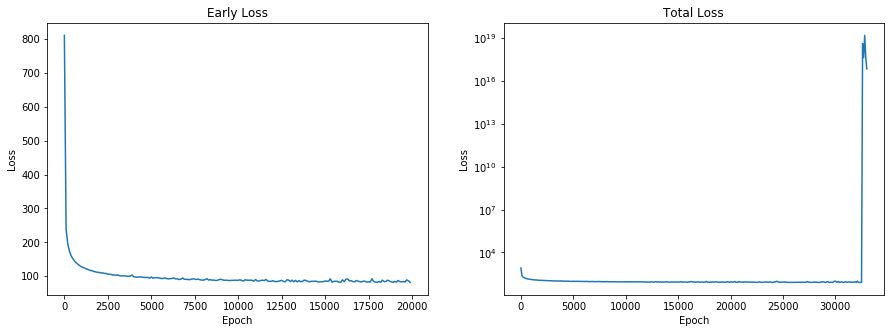

In [2]:
path = "../code/pyro_model/pyro.out"
text_file = open(path, "r")
lines = text_file.readlines()[4:-43]
epochs = [int(line.replace("]","").replace("\n","").split(" ")[1]) for line in lines]
loss = [float(line.replace("]","").replace("\n","").split(" ")[6]) for line in lines]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 2)
ax.plot(epochs,loss)
ax.set_title("Total Loss")
ax.set_yscale('log')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax = fig.add_subplot(1, 2, 1)
ax.plot(epochs[:200],loss[:200])
ax.set_title("Early Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()

We find that the model successfully trains and loss decreases to a value in the same rough range as the original model - however, after ~30,000 epochs loss explodes and the model fails.

Exactly why is not clear - likely, without any of the added features of the original model that improve performance, the model may not be as stable. With VAEs, instability can often arise from large KL divergence distances for the latent variables. One solution for this is to use a warm up scaling that only factors in KL divergence loss after a number of epochs, essentially allowing the model to learn the data first before factoring in the KLD loss. This feature is implemented in the full model, but implementation with pyro does not appear simple.

Moreover, because the SVI module and Trace_ELBO loss modules are black-box entities that offer little customisation, constructing this model served to make clear that pyro does not offer the flexibility required for this model. As such, subsequent endeavours sought to construct the model in PyTorch without additional libraries.